In [ ]:
# Read the Data from Text
def read_file(file_name): 
    data_list  = []
    with open(file_name, 'r') as f: 
        for line in f: 
            line = line.strip() 
            label = ' '.join(line[1:line.find("]")].strip().split())
            text = line[line.find("]")+1:].strip()
            data_list.append([label, text])
    return data_list 

In [ ]:
# Import Dataset
# Import File from Loacal Drive
# from google.colab import files
# data_to_load = files.upload()
from google.colab import drive
drive.mount('/content/drive')
file_name = '/content/drive/MyDrive/Files/data.txt'
psychExp_txt = read_file(file_name) 

Mounted at /content/drive


In [ ]:
# Total Entries of Data
print("The number of instances: {}".format(len(psychExp_txt)))

The number of instances: 7480


In [ ]:
# One Example of Data
print("Data example: ")
print(psychExp_txt[6932])

Data example: 
['0. 0. 0. 0. 0. 0. 1.', 'Made a mistake at work.']


In [ ]:
# Identifying Features
import re 
from collections import Counter

In [ ]:
# N-Gram
def ngram(token, n): 
    output = []
    for i in range(n-1, len(token)): 
        ngram = ' '.join(token[i-n+1:i+1])
        output.append(ngram) 
    return output

In [ ]:
# Feature creation
def create_feature(text, nrange=(1, 1)):
    text_features = [] 
    text = text.lower() 

    # 1. treat alphanumeric characters as word tokens
    # Since tweets contain #, we keep it as a feature
    # Then, extract all ngram lengths
    text_alphanum = re.sub('[^a-z0-9#]', ' ', text)
    for n in range(nrange[0], nrange[1]+1): 
        text_features += ngram(text_alphanum.split(), n)
    
    # 2. treat punctuations as word token
    text_punc = re.sub('[a-z0-9]', ' ', text)
    text_features += ngram(text_punc.split(), 1)
    
    # 3. Return a dictinaory whose keys are the list of elements 
    # and their values are the number of times appearede in the list.
    return Counter(text_features)

In [ ]:
# Few Examples!
print(create_feature("I love you!"))
print(create_feature(" Pawan is Good Guy!!!!!!  #Friends"))
print(create_feature(" Pawan is Good Guy!!!!!!  #Friends", (1, 2)))

Counter({'i': 1, 'love': 1, 'you': 1, '!': 1})
Counter({'pawan': 1, 'is': 1, 'good': 1, 'guy': 1, '#friends': 1, '!!!!!!': 1, '#': 1})
Counter({'pawan': 1, 'is': 1, 'good': 1, 'guy': 1, '#friends': 1, 'pawan is': 1, 'is good': 1, 'good guy': 1, 'guy #friends': 1, '!!!!!!': 1, '#': 1})


In [ ]:
# Converting them into Labels
def convert_label(item, name): 
    items = list(map(float, item.split()))
    label = ""
    for idx in range(len(items)): 
        if items[idx] == 1: 
            label += name[idx] + " "
    
    return label.strip()

In [ ]:
# Appending Emotions Rating
emotions = ["joy", 'fear', "anger", "sadness", "disgust", "shame", "guilt"]

X_all = []
y_all = []
for label, text in psychExp_txt:
    y_all.append(convert_label(label, emotions))
    X_all.append(create_feature(text, nrange=(1, 4)))

In [ ]:
# Features Example
print("features example: ")
print(X_all[6932])

features example: 
Counter({'made': 1, 'a': 1, 'mistake': 1, 'at': 1, 'work': 1, 'made a': 1, 'a mistake': 1, 'mistake at': 1, 'at work': 1, 'made a mistake': 1, 'a mistake at': 1, 'mistake at work': 1, 'made a mistake at': 1, 'a mistake at work': 1, '.': 1})


In [ ]:
# Label Example
print("Label example:")
print(y_all[0])

Label example:
joy


In [ ]:
# Creaing classifiers
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(X_all, y_all, test_size = 0.2, random_state = 123)

In [ ]:
# Convert the labeled features into sparse vectors
from sklearn.metrics import accuracy_score

def train_test(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test, clf.predict(X_test))
    
#     print("Training acc: {}".format(train_acc))
#     print("Test acc    : {}".format(test_acc))
    
    return train_acc, test_acc    

In [ ]:
# Using DictVectorizer
from sklearn.feature_extraction import DictVectorizer
vectorizer = DictVectorizer(sparse = True)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
# Training & Testing Classifiers
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Classifiers 
svc = SVC()
lsvc = LinearSVC(random_state=123)
rforest = RandomForestClassifier(random_state=123)
dtree = DecisionTreeClassifier()

clifs = [svc, lsvc, rforest, dtree]

# train and test them 
print("| {:25} | {} | {} |".format("Classifier", "Training Accuracy", "Test Accuracy"))
print("| {} | {} | {} |".format("-"*25, "-"*17, "-"*13))
for clf in clifs: 
    clf_name = clf.__class__.__name__
    train_acc, test_acc = train_test(clf, X_train, X_test, y_train, y_test)
    print("| {:25} | {:17.7f} | {:13.7f} |".format(clf_name, train_acc, test_acc))

| Classifier                | Training Accuracy | Test Accuracy |
| ------------------------- | ----------------- | ------------- |
| SVC                       |         0.9067513 |     0.4512032 |


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


| LinearSVC                 |         0.9988302 |     0.5768717 |
| RandomForestClassifier    |         0.9988302 |     0.5541444 |
| DecisionTreeClassifier    |         0.9988302 |     0.4565508 |


In [ ]:
# Model parameters Tuning
from sklearn.model_selection import GridSearchCV

parameters = {'C':[1, 2, 3, 5, 10, 15, 20, 30, 50, 70, 100], 
             'tol':[0.1, 0.01, 0.001, 0.0001, 0.00001]}

lsvc = LinearSVC(random_state=123)
grid_obj = GridSearchCV(lsvc, param_grid = parameters, cv=5)
grid_obj.fit(X_train, y_train)

print("Validation acc: {}".format(grid_obj.best_score_))
print("Training acc: {}".format(accuracy_score(y_train, grid_obj.predict(X_train))))
print("Test acc    : {}".format(accuracy_score(y_test, grid_obj.predict(X_test))))
print("Best parameter: {}".format(grid_obj.best_params_))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Validation acc: 0.5613304442823893
Training acc: 0.9988302139037433
Test acc    : 0.5768716577540107
Best parameter: {'C': 1, 'tol': 0.1}


In [ ]:
# Error Analysis
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, grid_obj.predict(X_test))
print(matrix)

[[112  27  16  23  12  19  19]
 [ 20 113  11  11  12  17   9]
 [  9  18 157   3  11  16  10]
 [ 19  12  15 107  12  17  36]
 [  7   9   7   7 155  18   8]
 [ 17   9  17  12  21 137  10]
 [ 31  19  10  30  17  10  82]]


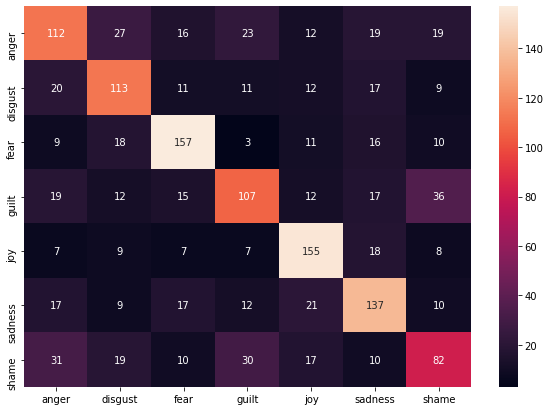

In [ ]:
# Heatmap of Emojis
%matplotlib inline
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

l = ["joy", 'fear', "anger", "sadness", "disgust", "shame", "guilt"]
l.sort()
df_cm = pd.DataFrame(matrix, index = l, columns = l)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.show()

In [ ]:
# Get counts for each label
label_freq = {}
for label, _ in psychExp_txt: 
    label_freq[label] = label_freq.get(label, 0) + 1

# print the labels and their counts in sorted order 
for l in sorted(label_freq, key=label_freq.get, reverse=True):
    print("{:10}({})  {}".format(convert_label(l, emotions), l, label_freq[l]))

joy       (1. 0. 0. 0. 0. 0. 0.)  1084
anger     (0. 0. 1. 0. 0. 0. 0.)  1080
sadness   (0. 0. 0. 1. 0. 0. 0.)  1079
fear      (0. 1. 0. 0. 0. 0. 0.)  1078
disgust   (0. 0. 0. 0. 1. 0. 0.)  1057
guilt     (0. 0. 0. 0. 0. 0. 1.)  1057
shame     (0. 0. 0. 0. 0. 1. 0.)  1045


In [ ]:
#Emoji Dictionary
emoji_dict = {"joy":"😂", "fear":"😱", "anger":"😠", "sadness":"😢", "disgust":"😒", "shame":"😳", "guilt":"😳"}

In [ ]:
# Prediction
t1 = "Thank you for dinner!"
t2 = "I don't like it"
t3 = "My car skidded on the wet street"
t4 = "My cat died"

texts = [t1, t2, t3, t4]
for text in texts: 
    features = create_feature(text, nrange=(1, 4))
    features = vectorizer.transform(features)
    prediction = grid_obj.predict(features)[0]
    print("{} {}".format(emoji_dict[prediction], text))

😂 Thank you for dinner!
😢 I don't like it
😱 My car skidded on the wet street
😢 My cat died
